##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

<!-- #@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License. -->

# TFP Probabilistic Layers: Variational Auto Encoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this example we show how to fit a Variational Autoencoder using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [1]:
#@title Import { display-mode: "form" }
import subprocess
import os
# Originally used to solve issue where some 
# LD_LIBRARY_PATH = os.environ['LD_LIBRARY_PATH']
# HOME = os.environ['HOME']
# os.environ["LD_LIBRARY_PATH"] = HOME+"/.conda/envs/py38/lib:"+LD_LIBRARY_PATH
# subprocess.run(["pip", "install", "tensorflow_datasets"])
# subprocess.run(["pip", "install", "tensorflow_probability"])

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# # TO SOLVE THE ISSUE from vae.fit, (UNIMPLEMENTED: DNN library is not found. or
# # InternalError: libdevice not found at ./libdevice.10.bc) arising from running TF and JAX concurrently
# # REFER TO: https://github.com/google/jax/issues/4920#issuecomment-1426065017
# # Reducing the allocation of memory by TF: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # # Currently, memory growth needs to be the same across GPUs
#     # for gpu in gpus:
#     #   tf.config.experimental.set_memory_growth(gpu, True)
#     # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
# # If the error (UNIMPLEMENTED: DNN library is not found. or InternalError: libdevice not found at ./libdevice.10.bc)
# # still persists restricting usage of GPU entirely by setting visiable devices
tf.config.experimental.set_visible_devices([], 'GPU')
# also try reducing JAX memory usage as below
# # JAX memory allocation: https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html#common-causes-of-oom-failures
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"



tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# verify that we have access to a GPU.
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

/home/ching.ki/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SUCCESS: Found GPU: /device:GPU:0


### Load Dataset

In [17]:
dataset_name = "distributed100atoms_dataset"

train_dataset = tf.data.Dataset.load("../dataset/m1_ssRNA_train_" + dataset_name)
test_dataset = tf.data.Dataset.load("../dataset/m1_ssRNA_test_" + dataset_name)

input_shape = train_dataset.element_spec[0].shape

def _preprocess(sample):
  ndarray = tf.cast(sample, tf.float32) / 255.  # Scale to unit interval.
  return ndarray, ndarray

train_dataset = (train_dataset
                 .shuffle(int(10e3))
                 .map(lambda data, label: data)
                 .map(_preprocess)
                 .batch(5)
                 .prefetch(tf.data.AUTOTUNE))
test_dataset = (test_dataset
                .shuffle(int(10e3))
                .map(lambda data, label: data)
                .map(_preprocess)
                .batch(5)
                .prefetch(tf.data.AUTOTUNE))

# check size of dataset
print(f'train: {train_dataset.cardinality().numpy()}')
print(f'test: {test_dataset.cardinality().numpy()}')

encoded_size = 64
base_depth = 32

train: 101
test: 101


Note that _preprocess() above returns `image, image` rather than just `image` because Keras is set up for discriminative models with an (example, label) input format, i.e. $p_\theta(y|x)$. Since the goal of the VAE is to recover the input x from x itself (i.e. $p_\theta(x|x)$), the data pair is (example, example).

### VAE Code Golf

#### Specify model.

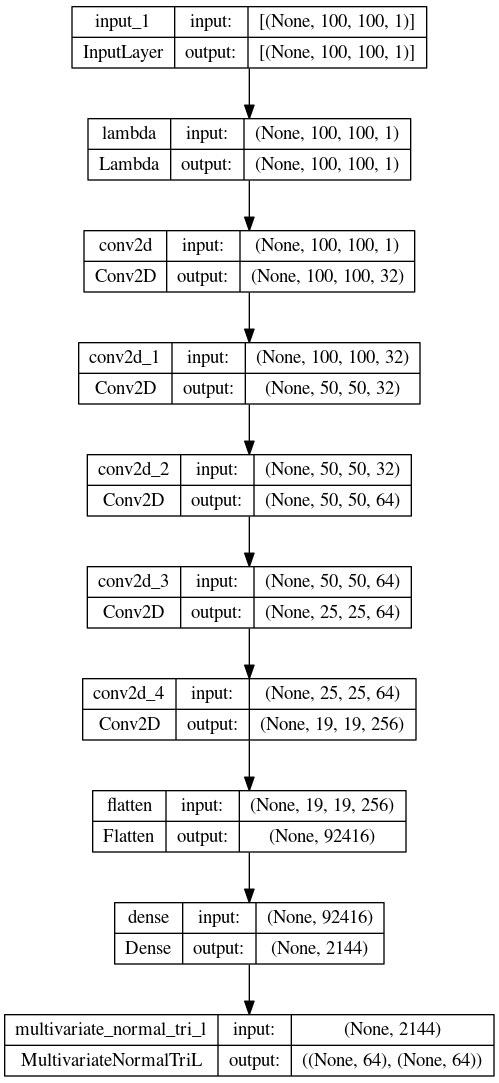

In [18]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 25, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

tf.keras.utils.plot_model(vae, show_shapes=True)
tf.keras.utils.plot_model(decoder, show_shapes=True)
tf.keras.utils.plot_model(encoder, show_shapes=True)

#### Do inference.

In [20]:
callbacks = [
    tfk.callbacks.TensorBoard(
        log_dir="../Tensorboard_log/m1_" + dataset_name,
        histogram_freq=1,  # How often to log histogram visualizations
        embeddings_freq=1,  # How often to log embedding visualizations
    )  
]

In [21]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(train_dataset,
            epochs=15,
            callbacks=callbacks,
            validation_data=test_dataset)

vae.save_weights("trained_model/encoded64_m1_ssRNA" + dataset_name)

Epoch 1/12
101/101 [==============================] - 214s 2s/step - loss: 1893.3552 - val_loss: 691.7409
Epoch 2/12
101/101 [==============================] - 203s 2s/step - loss: 676.3253 - val_loss: 666.3251
Epoch 3/12
101/101 [==============================] - 199s 2s/step - loss: 660.5374 - val_loss: 655.5385
Epoch 4/12
101/101 [==============================] - 194s 2s/step - loss: 652.9358 - val_loss: 651.5724
Epoch 5/12
101/101 [==============================] - 194s 2s/step - loss: 652.4903 - val_loss: 651.5049
Epoch 6/12
101/101 [==============================] - 193s 2s/step - loss: 651.2880 - val_loss: 652.0704
Epoch 7/12
101/101 [==============================] - 184s 2s/step - loss: 650.5741 - val_loss: 649.5530
Epoch 8/12
101/101 [==============================] - 173s 2s/step - loss: 649.4514 - val_loss: 649.1505
Epoch 9/12
101/101 [==============================] - 169s 2s/step - loss: 650.1379 - val_loss: 649.4882
Epoch 10/12
101/101 [==============================] -

### Look Ma, No ~~Hands~~Tensors!

In [ ]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

In [15]:
#@title Image Plot Util
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

Originals:


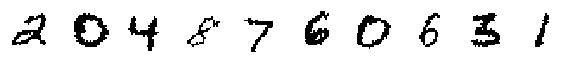

Decoded Random Samples:


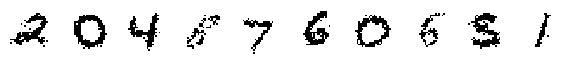

Decoded Modes:


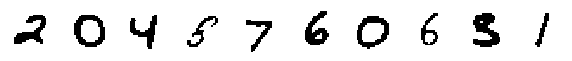

Decoded Means:


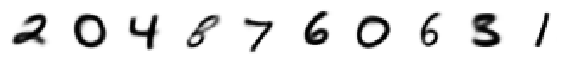

In [16]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [24]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

Randomly Generated Samples:


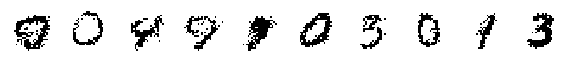

Randomly Generated Modes:


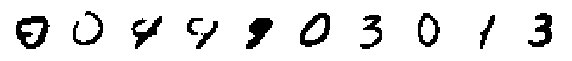

Randomly Generated Means:


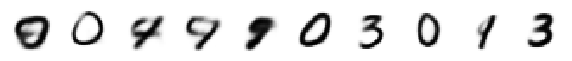

In [25]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

### ARCHIVED

In [4]:
# datasets, datasets_info = tfds.load(name='mnist',
#                                     with_info=True,
#                                     as_supervised=False)

# def _preprocess(sample):
#   image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
#   image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
#   return image, image

# train_dataset = (datasets['train']
#                  .map(_preprocess)
#                  .batch(256)
#                  .prefetch(tf.data.AUTOTUNE)
#                  .shuffle(int(10e3)))
# eval_dataset = (datasets['test']
#                 .map(_preprocess)
#                 .batch(256)
#                 .prefetch(tf.data.AUTOTUNE))
# input_shape = datasets_info.features['image'].shape